In [1]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import time
import progressbar
import warnings
import copy
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn import ReLU

from multiprocessing import cpu_count
from torch.multiprocessing import Pool

%matplotlib inline
plt.style.use('seaborn')

warnings.filterwarnings("ignore")
torch.set_num_threads(1)

In [3]:
def read_data_from_csv(path):
    df = pd.read_csv(path)
    X = df["sequence"].values
    y = df["label"].values
    y_names = df["class_name"].values
    return X, y, y_names

In [4]:
def load_train_val_test_data(level, analyze=True, return_label_names=False):
    data_base_path = "../data/hierarchy/" + level
    train_sequences, train_labels, train_label_names = read_data_from_csv(os.path.join(data_base_path, "train.csv"))
    val_sequences, val_labels, val_label_names = read_data_from_csv(os.path.join(data_base_path, "val.csv"))
    test_sequences, test_labels, test_label_names = read_data_from_csv(os.path.join(data_base_path, "test.csv"))
    
    if analyze:
        a = list(map(lambda x: len(x), train_sequences))
        print("DNA Sequence Length Statistics:")
        print("Max:", np.max(a))
        print("Min:", np.min(a))
        print("Mean:", np.ceil(np.mean(a)))
        print("Median:", np.ceil(np.median(a)))
        print("Sqrt of Max:", np.ceil(np.sqrt(np.max(a))))
    if return_label_names:
        return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_label_names
    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

In [5]:
IMAGE_WIDTH = IMAGE_HEIGHT = 21  # 441 length zero-padded DNA sequences
IMAGE_CHANNELS = 4  # A, C, G, T

base_pair_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'X': [0, 0, 0, 0]
}

def seqeunces_to_image(sequences):
    image = np.zeros((len(sequences), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    for i, sequence in enumerate(sequences):
        for loc, base_pair in enumerate(sequence):
            row = loc // IMAGE_HEIGHT
            col = loc % IMAGE_HEIGHT
            image[i, row, col] = base_pair_map[base_pair]
    return image

In [6]:
# analyze sequences to get the image size
train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = load_train_val_test_data("phylum")

DNA Sequence Length Statistics:
Max: 440
Min: 400
Mean: 422.0
Median: 423.0
Sqrt of Max: 21.0


In [7]:
base_pair_colors = {
    (1, 0, 0, 0): [183, 28, 28],  # red
    (0, 1, 0, 0): [174, 234, 0],  # green
    (0, 0, 1, 0): [0, 145, 234],  # blue
    (0, 0, 0, 1): [255, 111, 0],  # orange
    (0, 0, 0, 0): [33, 33, 33]   # black
}

base_pair_char = {
    (1, 0, 0, 0): "A",
    (0, 1, 0, 0): "C",
    (0, 0, 1, 0): "G",
    (0, 0, 0, 1): "T",
    (0, 0, 0, 0): "X"
}

def viz_dna_image(dna_image, log=False):
    w, h, _ = dna_image.shape
    dna_rgb_image = np.zeros((w, h, 3))
    dna_char_image = np.empty((w, h), dtype="U10")
    for i, row in enumerate(dna_image):
        for j, col in enumerate(row):
            dna_rgb_image[i][j] = base_pair_colors[tuple(col)]
            dna_char_image[i][j] = base_pair_char[tuple(col)]
    plt.grid(b=None)

    if log:
        print("DNA Sequence:\n", dna_char_image.flatten())
        print("DNA Block:\n", dna_char_image)
        print("DNA QRCode:")
    plt.imshow(dna_rgb_image/255.0)

In [8]:
def create_pytorch_datasets(data, labels):
    tensor_x = torch.stack([torch.Tensor(np.swapaxes(i, 0, 2)) for i in data]) # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in labels]).long().view(-1)

    dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloader = utils.DataLoader(dataset, batch_size=BATCH_SIZE) # create your dataloader
    
    return dataloader

DNA Sequence:
 ['G' 'A' 'C' 'G' 'A' 'T' 'T' 'A' 'G' 'T' 'G' 'G' 'C' 'X' 'X' 'X']
DNA Block:
 [['G' 'A' 'C' 'G']
 ['A' 'T' 'T' 'A']
 ['G' 'T' 'G' 'G']
 ['C' 'X' 'X' 'X']]
DNA QRCode:


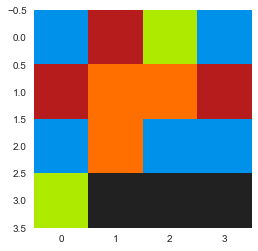

In [10]:
# Sample DNA Image Viz
sample_dna_sequence = "GACGATTAGTGGCXXX"  # 13bp length
dna_image = np.array([base_pair_map[c] for c in list(sample_dna_sequence)]).reshape(4, 4, 4)
viz_dna_image(dna_image, log=True)

2


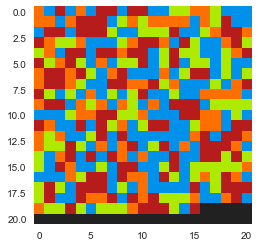

In [76]:
train_data = seqeunces_to_image(train_sequences)
viz_dna_image(train_data[0])
print(train_labels[0])